In [1]:
!pip install catalax

In [1]:
import json
import jax.numpy as jnp
import catalax as ctx
import catalax.neural as ctn
from tqdm import tqdm
import numpy as np
import catalax as ctx
import catalax.mcmc as cmc

# Pretraining 

In [2]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[k_p2ga_pgm, k_p3ga_pgm, keq_pgm, vf_pgm, vf_eno, k_PEP_eno, keq_eno, k_p2ga_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,k_PEP_eno,k_PEP_eno,0.50,False,None,None,None,None
1,k_p2ga_eno,k_p2ga_eno,0.04,False,None,None,None,None
2,k_p2ga_pgm,k_p2ga_pgm,0.08,False,None,None,None,None
3,k_p3ga_pgm,k_p3ga_pgm,1.20,False,None,None,None,None
4,keq_eno,keq_eno,6.70,False,None,None,None,None
5,keq_pgm,keq_pgm,0.19,False,None,None,None,None
6,vf_eno,vf_eno,1.35,False,None,None,None,None
7,vf_pgm,vf_pgm,9.40,False,None,None,None,None


## Training Set 

In [3]:
data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Data_Training_Set_1_20242309.npy")
time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Time_Training_Set_1_20240923.npy")
y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Training_Set_1_Initials_20242309.npy")
initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 1/Corrected_model_1_20242309.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)



Time: (30, 15) | Data: (30, 15, 3) | Initial Conditions: (30, 3)
(30, 15, 3)
(30, 15)
(30, 3)


## Validation set 

In [4]:
val_data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Data Set A/Data_Validation_Set_A_20242309.npy")
val_time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Data Set A/Time_Validation_Set_A_20242309.npy")
val_y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Data Set A/Validation_Set_A_Initials_20242309.npy")
val_initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Data Set A/Corrected_model_Validation_Set_A_20242309.json", "r"))  

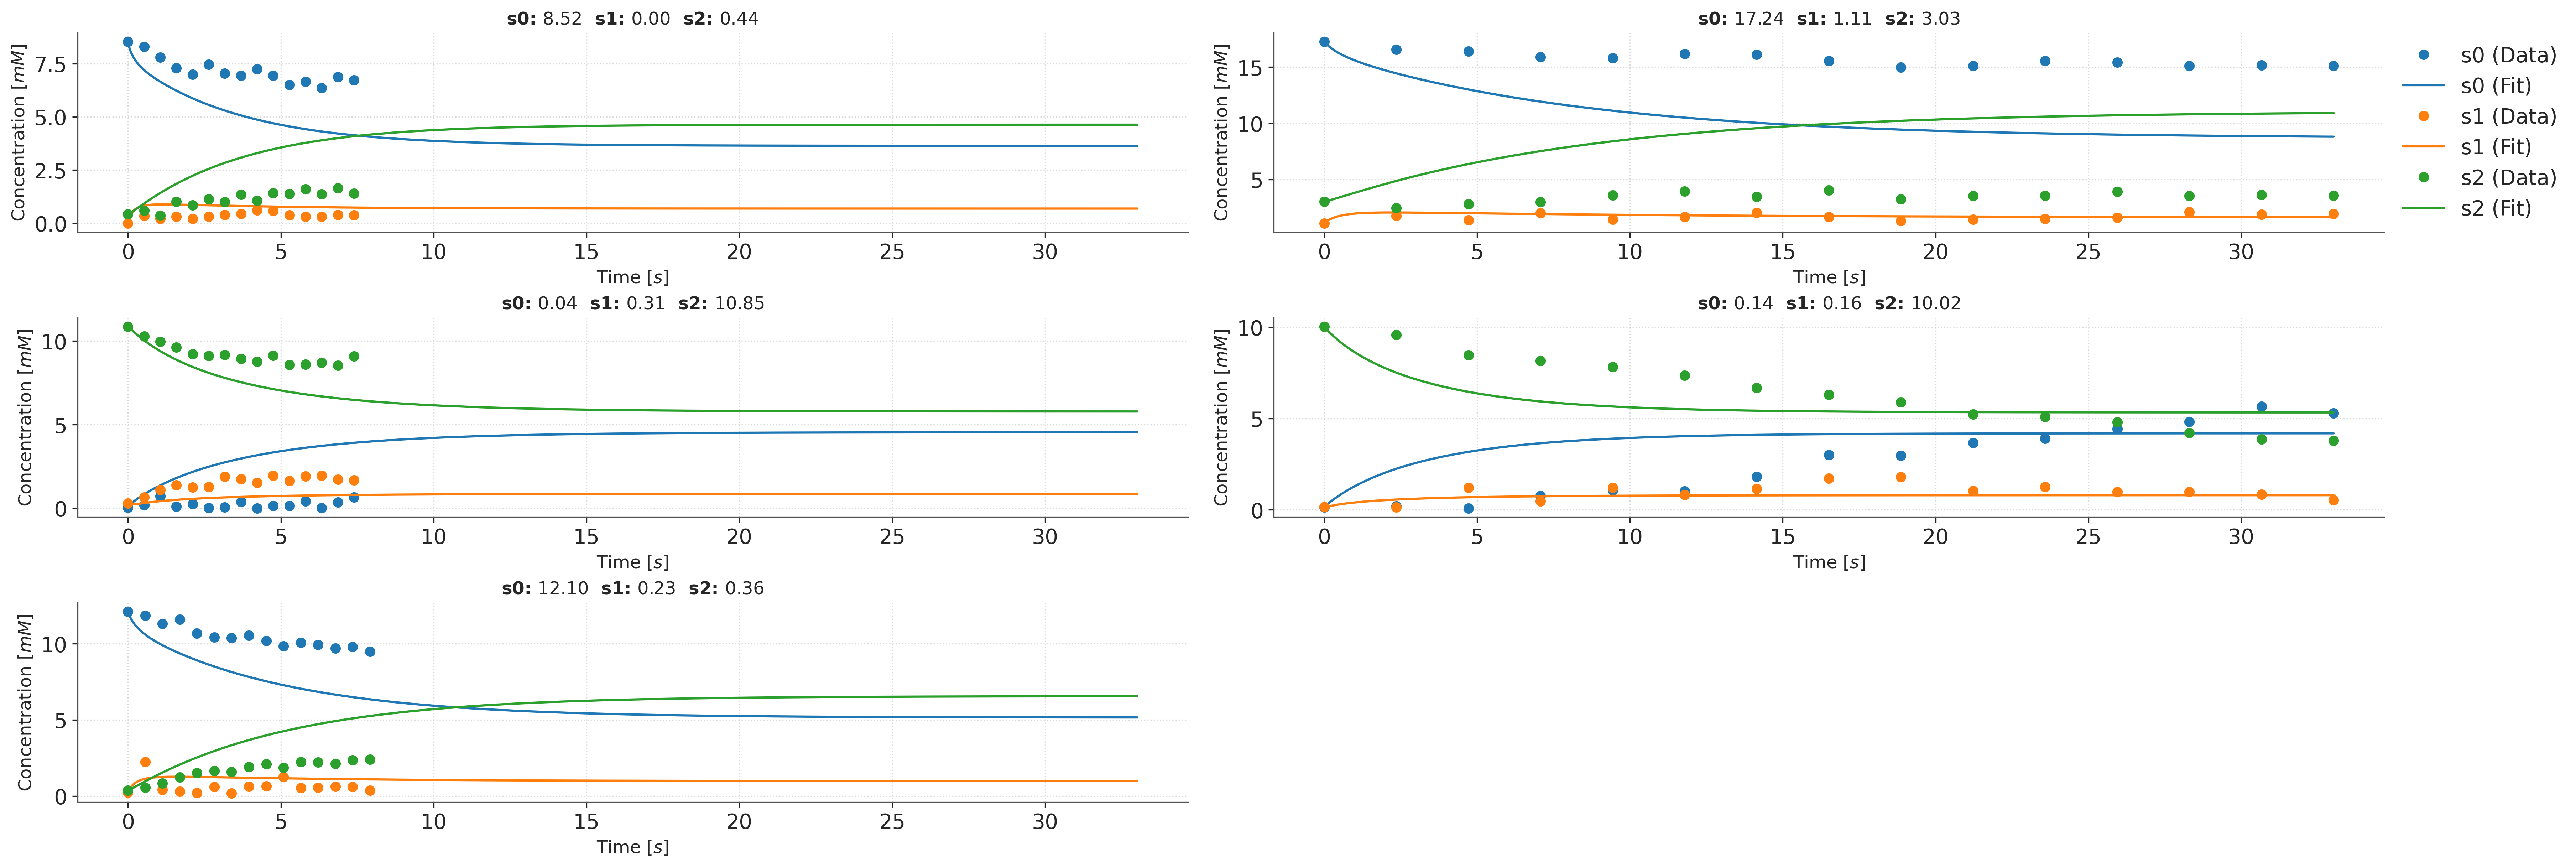

In [5]:
# Visualize the data
f = ctx.visualize(
    model=model,
    data=data[:5],
    times=time[:5],
    initial_conditions=initial_conditions[:5],
    figsize=(8,4),
)

# Training 

In [6]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(model, width_size=16, depth=1, activation=rbf)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=10000, batch_size=20, alpha=0.1)
strategy.add_step(lr=1e-3, steps=30000, batch_size=20, alpha=0.01)
strategy.add_step(lr=1e-4, steps=50000, batch_size=20, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    data=data,
    times=time,
    inital_conditions=y0s,
    strategy=strategy,
    sigma=0.03,
    n_augmentations=10,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False, # Set to True to save model checkpoints
    #log="progress.log", # Uncomment this line to log progress
)

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\neural\rbf.py:25: FutureWarning: uniform accepts a single key, but was given a key array of shape (1, 2) != (). Use jax.vmap for batching. In a future JAX version, this will be an error.
  self.mu = jax.random.uniform(mukey, (width_size,))



🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 20
├── length: 10.0%
├── l2 reg: 0.1
├── train: mlp
│


╰── loss: 0.0793 mae: 0.2151: : 10010it [02:43, 61.31it/s]                                                             




🔸 Step #2
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.1087 mae: 0.3354: : 30010it [11:27, 43.63it/s]                                                             




🔸 Step #3
├── lr: 0.0001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.0888 mae: 0.2956: : 50010it [18:28, 45.11it/s]                                                             

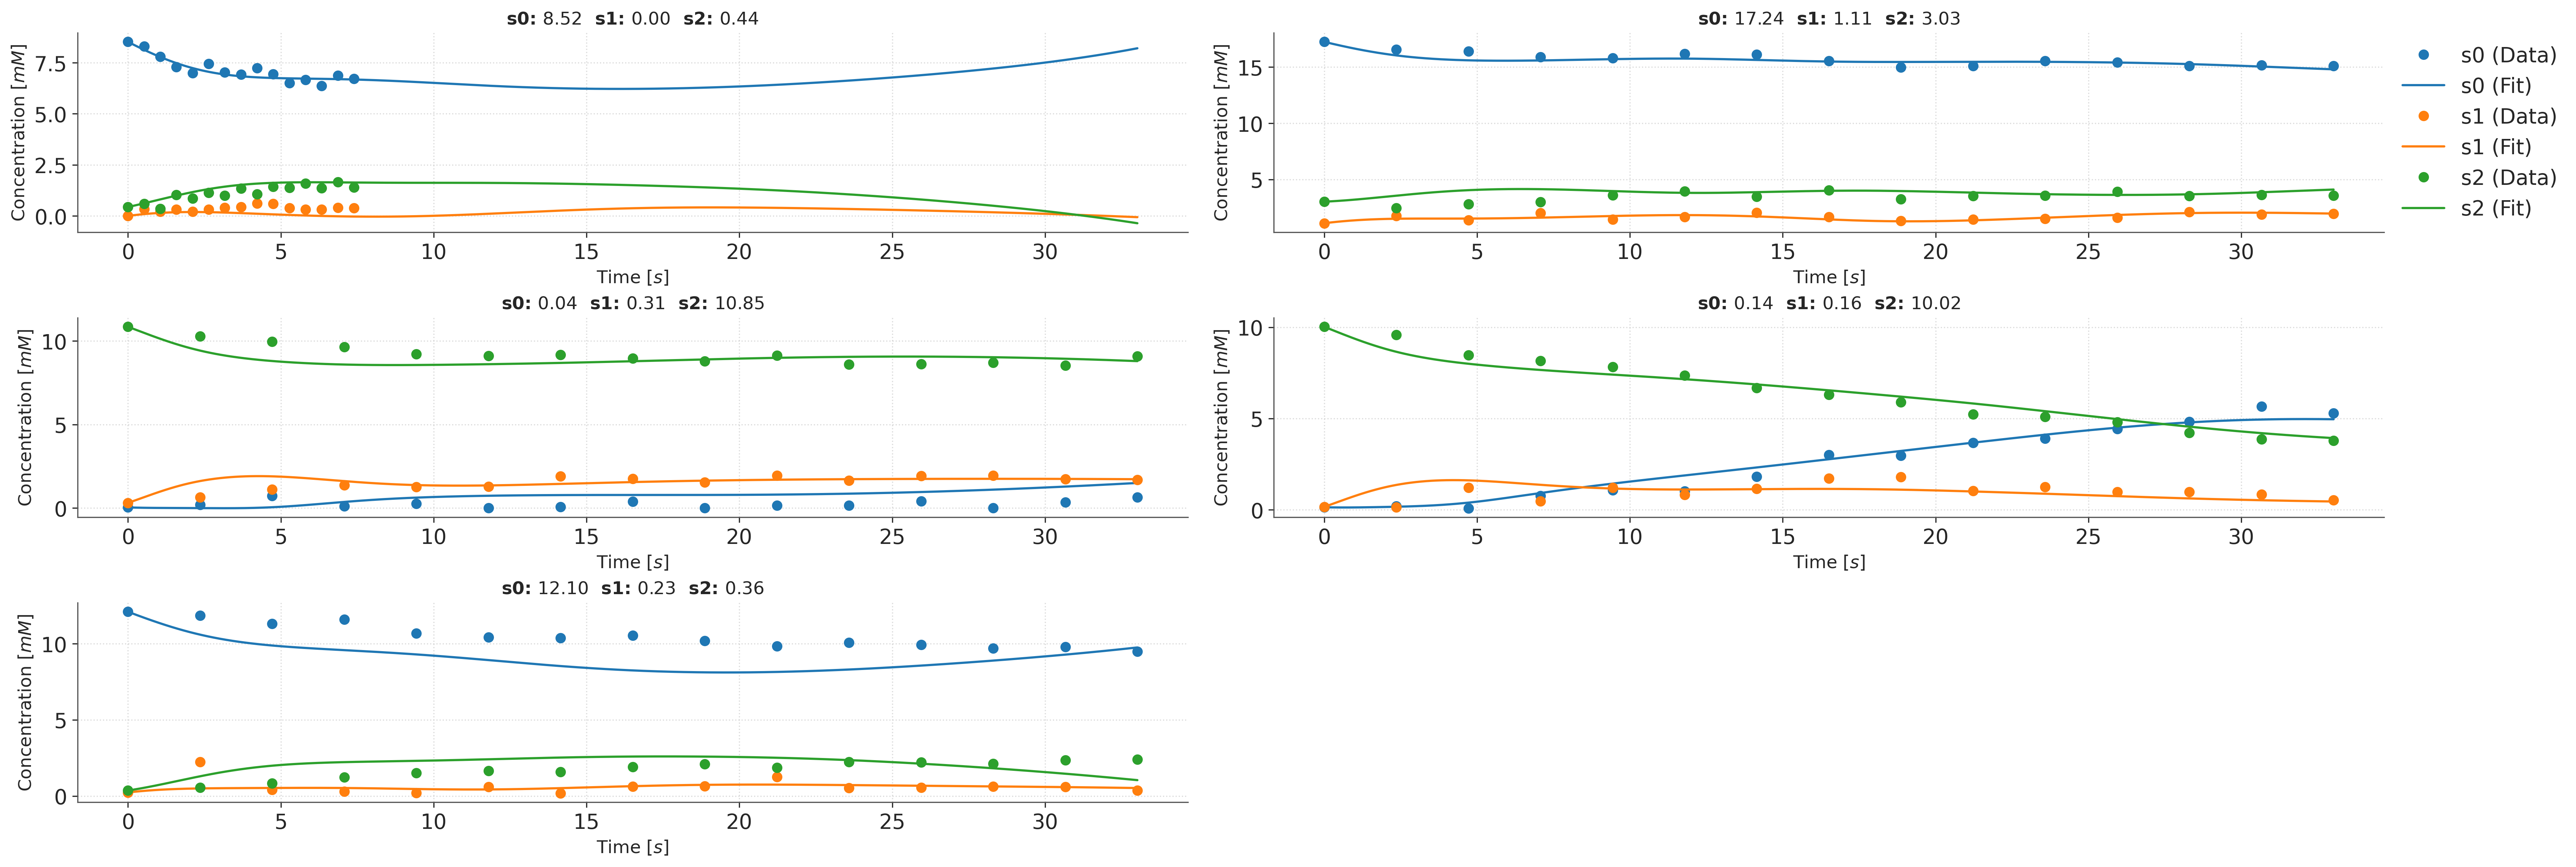

In [7]:
# Save model and visualize fit
trained.save_to_eqx("C:/Users/danic/OneDrive/Desktop/", "Set 1 Trained")
f = ctx.visualize(
    model=model,
    data=data[:5],
    times=time[:2],
    neural_ode=trained,
    initial_conditions=initial_conditions[:5],
    figsize=(8,4),
)

# Fit 

In [8]:
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

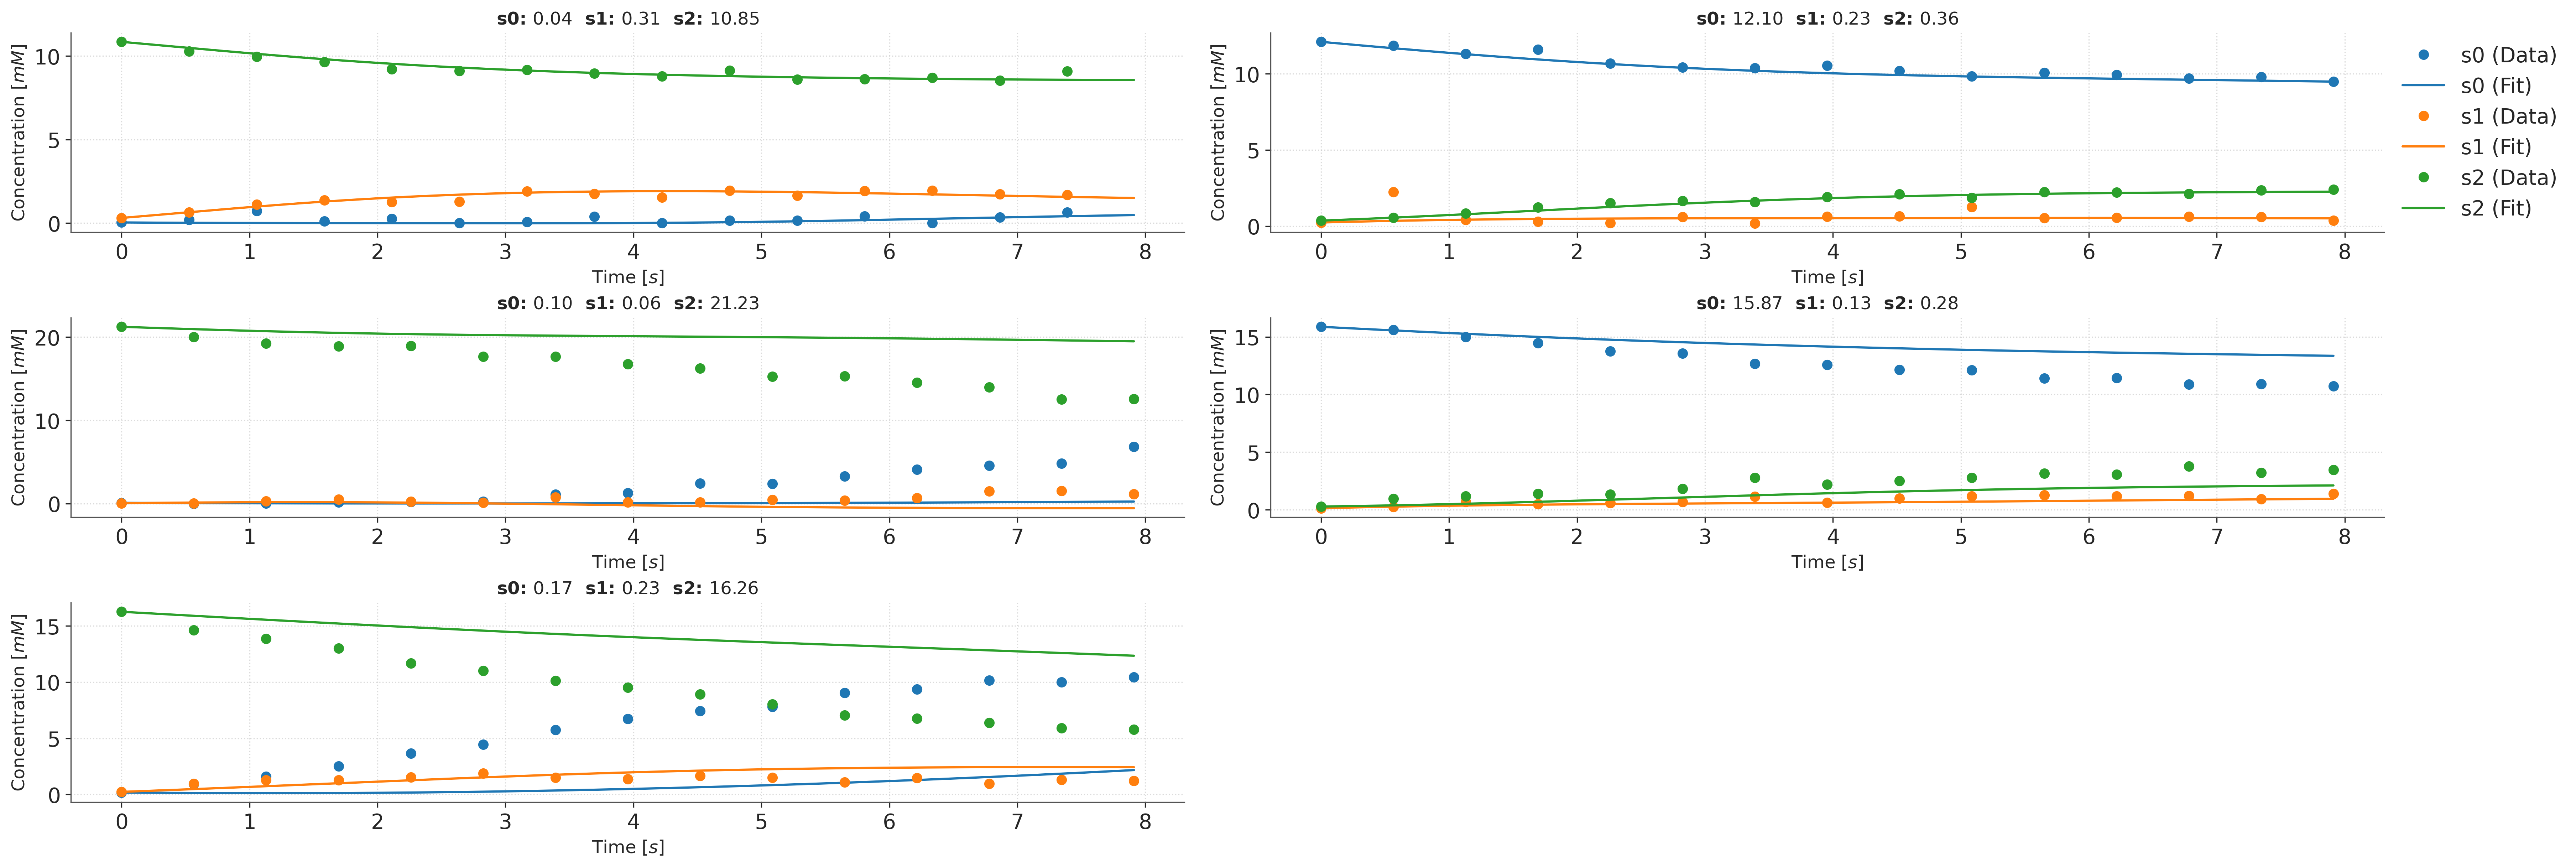

In [20]:
f = ctx.visualize(
    model=model,
    data=val_data[:5],
    times=val_time[:2],
    neural_ode=trained,
    initial_conditions=val_initial_conditions[:5],
    figsize=(8,4),
)

In [38]:
f.get_axes()

[<Axes: title={'center': 's0: $0.04$  s1: $0.31$  s2: $10.85$'}, xlabel='Time [s]', ylabel='Concentration [$mM$]'>,
 <Axes: title={'center': 's0: $12.10$  s1: $0.23$  s2: $0.36$'}, xlabel='Time [$s$]', ylabel='Concentration [$mM$]'>,
 <Axes: title={'center': 's0: $0.10$  s1: $0.06$  s2: $21.23$'}, xlabel='Time [$s$]', ylabel='Concentration [$mM$]'>,
 <Axes: title={'center': 's0: $15.87$  s1: $0.13$  s2: $0.28$'}, xlabel='Time [$s$]', ylabel='Concentration [$mM$]'>,
 <Axes: title={'center': 's0: $0.17$  s1: $0.23$  s2: $16.26$'}, xlabel='Time [$s$]', ylabel='Concentration [$mM$]'>,
 <Axes: >]

In [30]:
ax0.set_xlabel('Time [s]', fontsize=20)

Text(0.5, 1681.6666666666665, 'Time [s]')

In [36]:
f.set_figwidth(12)
f.set_figheight(10)

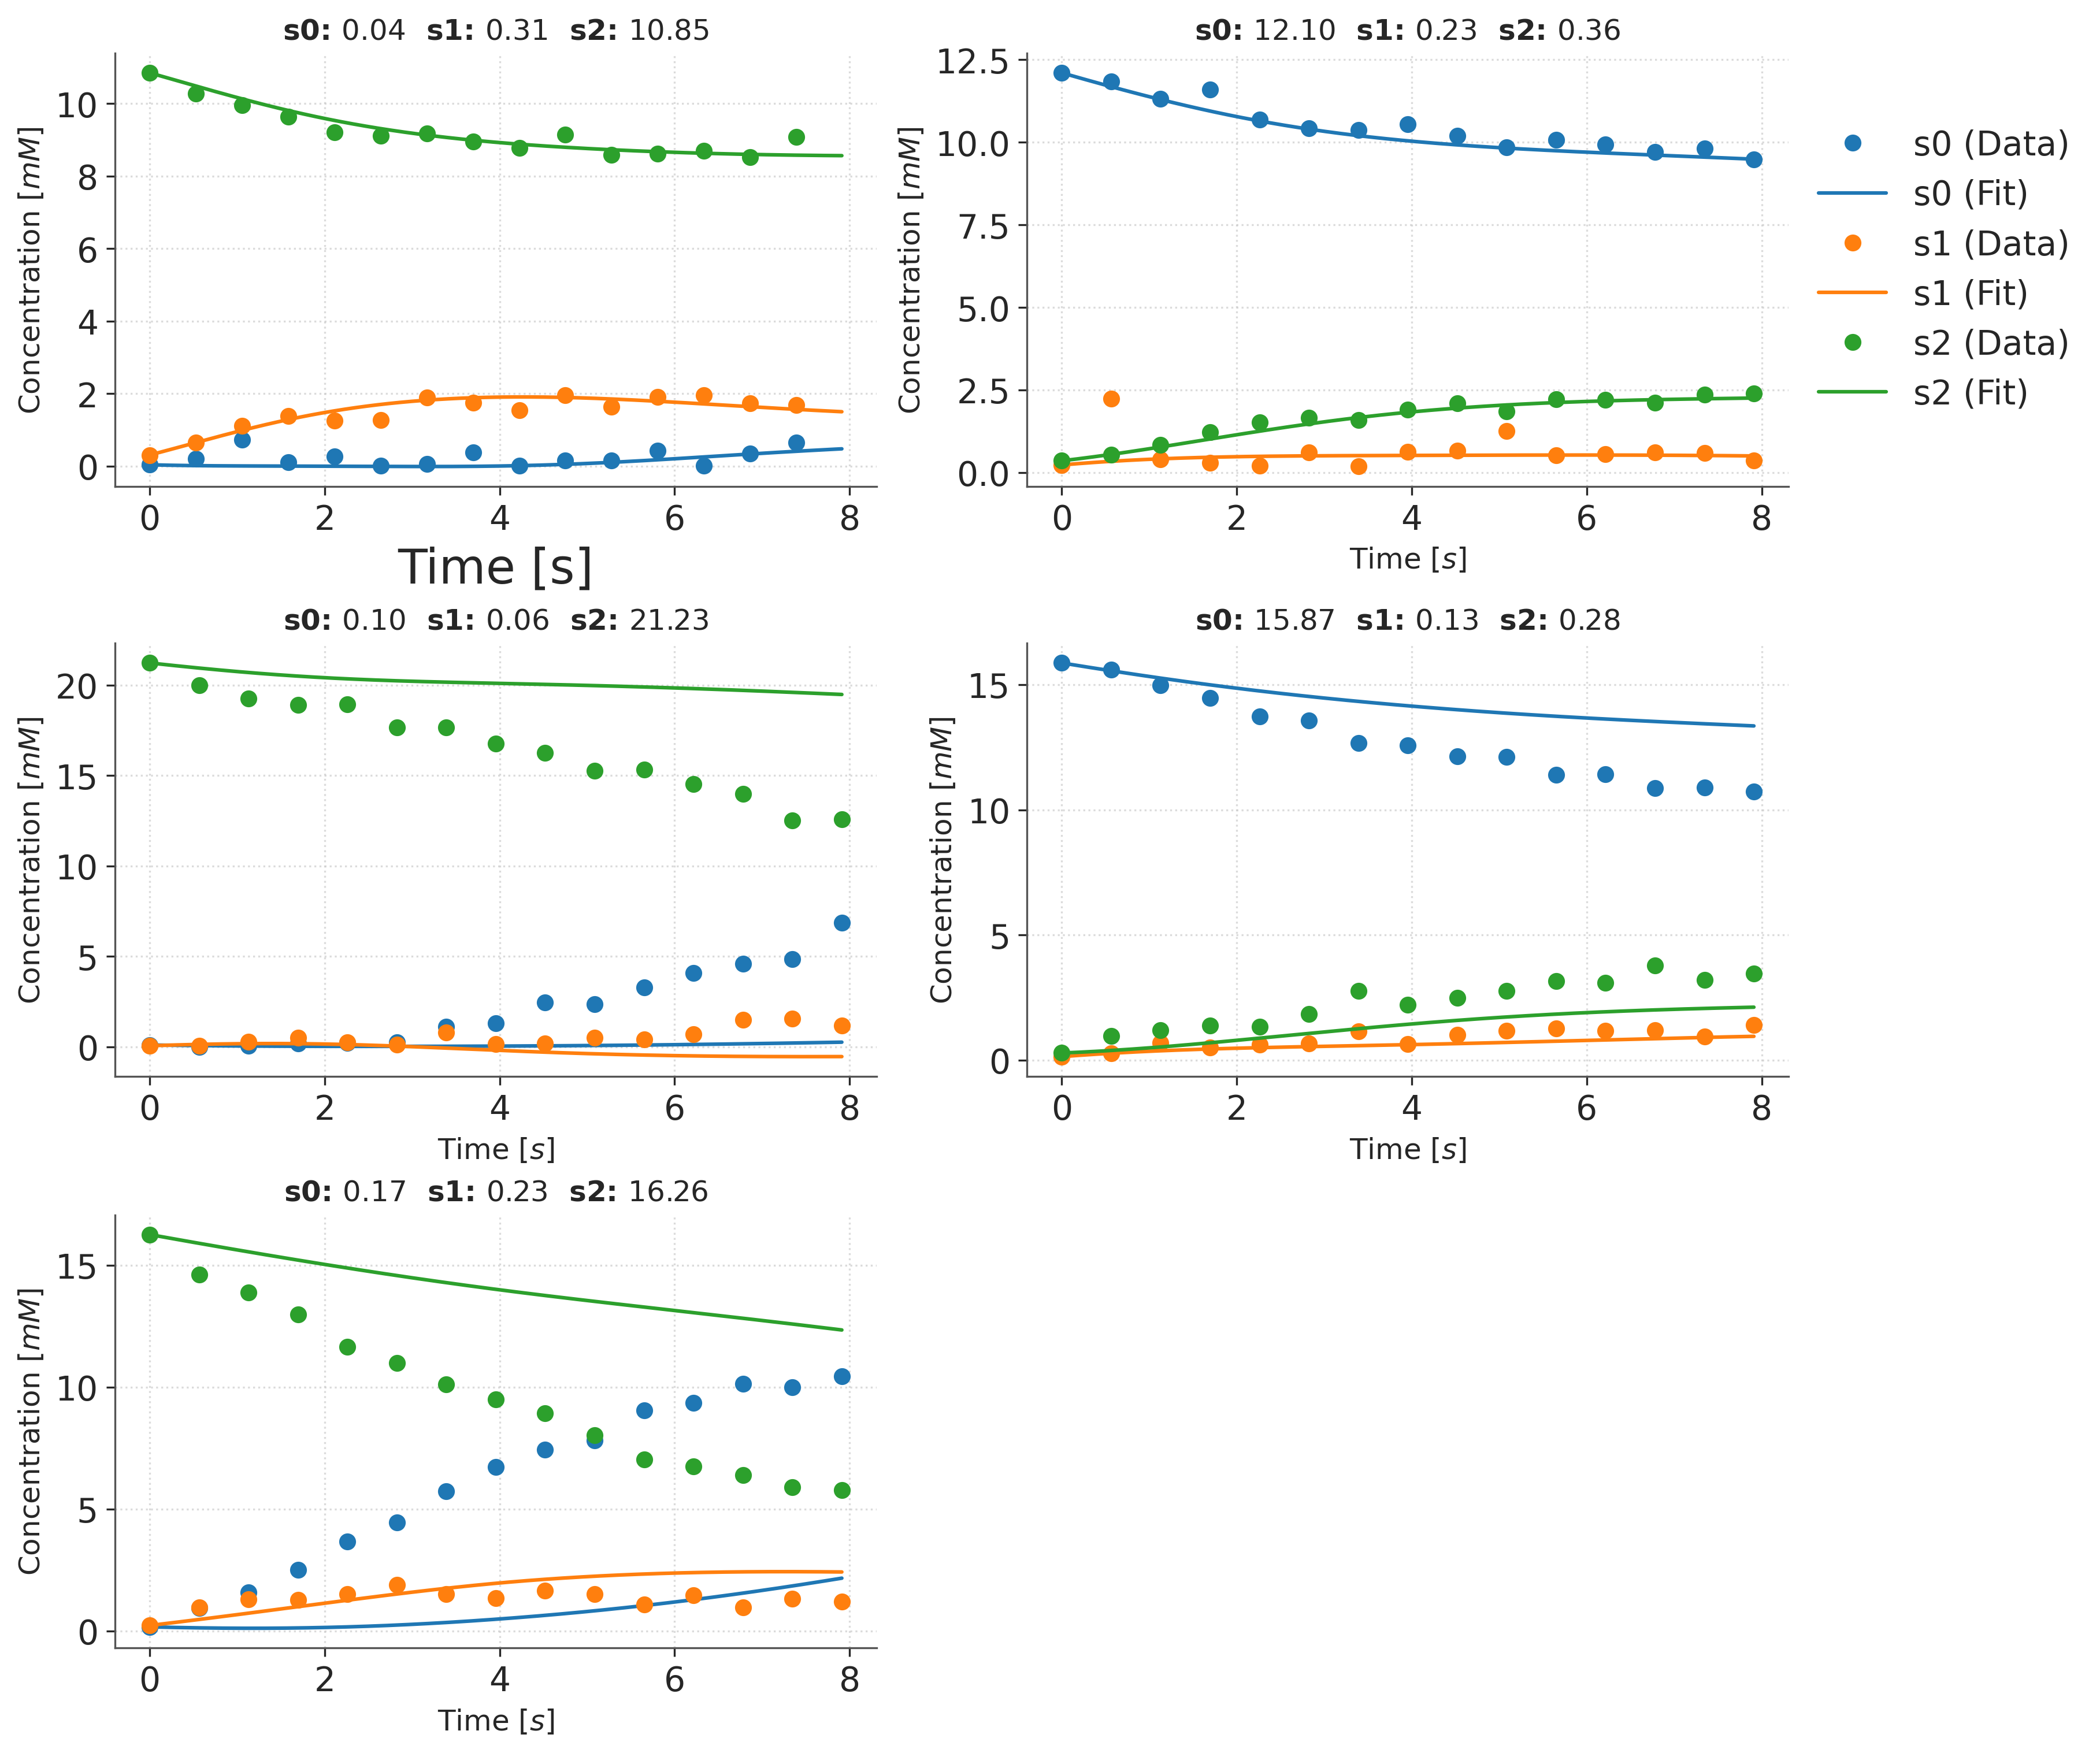

In [37]:
f

In [25]:
ax0.get_title()

's0: $0.04$  s1: $0.31$  s2: $10.85$'

In [10]:
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=val_initial_conditions,
    data=val_data,
    times=val_time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

# HMC 

In [9]:
# Assuming `trained_model` is your trained Neural ODE model
new_model


Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[vf_pgm, keq_pgm, k_p3ga_pgm, k_p2ga_pgm, keq_eno, k_PEP_eno, vf_eno, k_p2ga_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,k_PEP_eno,k_PEP_eno,1.239823,False,0.50,None,0.000001,100000.0
1,k_p2ga_eno,k_p2ga_eno,0.949516,False,0.04,None,0.000001,100000.0
2,k_p2ga_pgm,k_p2ga_pgm,0.380484,False,0.08,None,0.000001,100000.0
3,k_p3ga_pgm,k_p3ga_pgm,1.615028,False,1.20,None,0.000001,100000.0
4,keq_eno,keq_eno,4.605528,False,6.70,None,0.000001,100000.0
5,keq_pgm,keq_pgm,0.090394,False,0.19,None,0.000001,100000.0
6,vf_eno,vf_eno,1.290347,False,1.35,None,0.000001,100000.0
7,vf_pgm,vf_pgm,9.256761,False,9.40,None,0.000001,100000.0


In [13]:
# Prepare the model for bayes and define priors based on the parameters produced by the Neural ODE 
model.parameters.vf_eno.value = 1.290347
model.parameters.vf_pgm.value = 9.256761		
model.parameters.keq_pgm.value = 0.090394		
model.parameters.keq_eno.value = 4.605528
model.parameters.k_p2ga_pgm.value = 0.380484		
model.parameters.k_p3ga_pgm.value = 1.615028			
model.parameters.k_p2ga_eno.value = 0.949516	
model.parameters.k_PEP_eno.value = 1.239823	

In [18]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-6, high=1e2)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-6, high=1e2)


# Save the model and its priors
model.save("C:/Users/danic/OneDrive/Desktop", "menten_model_w_priors_Mel")

In [19]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=1000,
    dt0=0.3,
    max_steps=64**4
)

🔸 Priors
├── k_p2ga_pgm: U(low=1e-06, high=100.0)
├── k_p3ga_pgm: U(low=1e-06, high=100.0)
├── keq_pgm: U(low=1e-06, high=100.0)
├── vf_pgm: U(low=1e-06, high=100.0)
├── vf_eno: U(low=1e-06, high=100.0)
├── k_PEP_eno: U(low=1e-06, high=100.0)
├── keq_eno: U(low=1e-06, high=100.0)
├── k_p2ga_eno: U(low=1e-06, high=100.0)

🚀 Running MCMC



sample: 100%|███████████████████████████| 2000/2000 [41:05<00:00,  1.23s/it, 63 steps of size 5.61e-02. acc. prob=0.83]



🎉 Finished

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   k_PEP_eno      0.36      0.27      0.30      0.02      0.72    625.44      1.00
  k_p2ga_eno      7.39      6.14      5.66      0.17     15.53    485.20      1.01
  k_p2ga_pgm      0.07      0.06      0.05      0.01      0.15    385.64      1.00
  k_p3ga_pgm     68.27     22.83     72.25     33.75     99.93    131.16      1.00
     keq_eno      3.53      0.23      3.53      3.11      3.87    573.34      1.00
     keq_pgm      0.10      0.01      0.10      0.09      0.12    541.45      1.00
       sigma      1.02      0.02      1.02      0.99      1.05    821.75      1.00
      vf_eno     66.81     23.70     71.59     32.48     99.96    183.37      1.01
      vf_pgm     40.47     25.21     33.43      8.33     84.24    240.13      1.00

Number of divergences: 21


In [ ]:
##### Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue
    
    model.parameters[param].value = float(samples.mean())
    
model.parameters

In [ ]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

In [ ]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(8,4),
    mcmc=mcmc
)